In [14]:
import numpy as np
import pandas as pd
import networkx as nx
import hdbscan
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics.pairwise import pairwise_distances

import matplotlib.pyplot as plt

rng = np.random.default_rng(2)

In [2]:
n_authors=20
author_idx = pd.CategoricalIndex((f'author_{i:>02}' for i in range(1,n_authors+1)))

friendships = nx.random_tree(n_authors+1, seed=42) # real events... what "happens" as evidence of a relationship
author_rel = nx.relabel.relabel_nodes(nx.convert_node_labels_to_integers(nx.line_graph(friendships)),dict(zip(range(n_authors),author_idx.categories.tolist())))  # inferred structure

incidence = (
    pd.Series.sparse.from_coo(nx.incidence_matrix(author_rel, oriented=True).tocoo())#.set_index(author_idxlevel=0)%%!
    .pipe(lambda df: df.set_axis(df.index.set_levels(author_idx, level=0).swaplevel()))
    .sort_index()
    .astype('Sparse[int]')
)
incidence.head()



/tmp/ipykernel_3596652/463850311.py:8: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  pd.Series.sparse.from_coo(nx.incidence_matrix(author_rel, oriented=True).tocoo())#.set_index(author_idxlevel=0)%%!


0  author_01   -1
   author_14    1
1  author_02   -1
   author_15    1
2  author_02   -1
dtype: Sparse[int64, 0]

In [3]:
B = incidence.unstack().fillna(0.)
L = B.T@B
B.head()

,author_01,author_02,author_03,author_04,author_05,author_06,author_07,author_08,author_09,author_10,author_11,author_12,author_13,author_14,author_15,author_16,author_17,author_18,author_19,author_20
0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
def sim_papers(n_weeks, L): 
    Arw = ((L/np.diag(L)).pipe(lambda df: np.diag(np.diag(df))-df)*0.5)
    def sim_week(): 
        n_jumps = rng.geometric(0.3)
        first = rng.multinomial(1,starting:=np.ones(n_authors)/n_authors) 
        second = (rng.random()>0.5)*rng.multinomial(1,starting)  # maybe
        infected = first | second
        for jump in range(n_jumps):
            infected = infected | rng.binomial(1, Arw@(infected))
        return infected
    yield from (sim_week() for i in range(n_weeks))


papers = pd.DataFrame(
    # np.where(rng.multivariate_normal(np.zeros(n_authors), np.linalg.inv(np.eye(n_authors) + L), size=100)>0.3, 1,0),
    sim_papers(100, L),
    columns=author_idx
).rename_axis(index='week', columns='author')

In [75]:
papers

author,author_01,author_02,author_03,author_04,author_05,author_06,author_07,author_08,author_09,author_10,author_11,author_12,author_13,author_14,author_15,author_16,author_17,author_18,author_19,author_20
week,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,1,0,0,0,1
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
96,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
97,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [85]:
# dists = pd.DataFrame(squareform(pdist((metadf:=papers.assign(meta=1)).T, metric='sqeuclidean')), columns=metadf.columns, index=metadf.columns)
# dists = pd.DataFrame(squareform(pdist((metadf:=papers.assign(meta=1)).T, metric='jaccard')), columns=metadf.columns, index=metadf.columns)
# dists = pd.DataFrame(squareform(pdist((metadf:=papers.assign(meta=1)), metric='cosine')), columns=metadf.index, index=metadf.index)
dists = pairwise_distances(papers.assign(meta=1), metric='cosine')

# dists = np.sqrt(1-(1-dists)**2)

clust = hdbscan.HDBSCAN(
    metric='precomputed', 
    # prediction_data=True
)
# clust.fit(pairwise_distances(papers.assign(meta=1), metric='cosine'))
clust.fit(dists)

HDBSCAN(metric='precomputed')

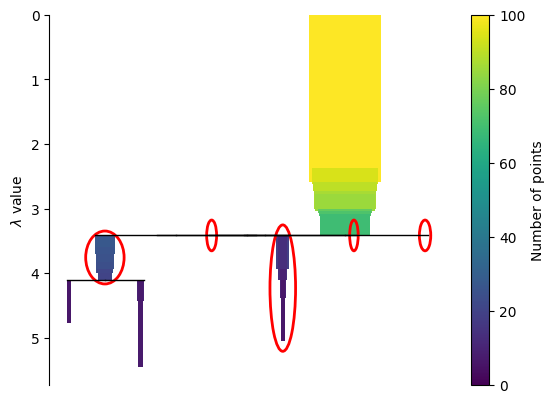

In [86]:
clust.condensed_tree_.plot(select_clusters=True)
from hdbscan.validity import all_points_core_distance



In [87]:
# np.maximum.outer(kcore:=all_points_core_distance(dists, d=n_authors), kcore)
all_points_core_distance(dists, d=n_authors)
dists

/home/tbsexton/.pyenv/versions/affinis/lib/python3.10/site-packages/hdbscan/validity.py:30: RuntimeWarning: overflow encountered in power
  distance_matrix[distance_matrix != 0] = (1.0 / distance_matrix[


array([[           inf, 3.15336855e+02, 3.15336855e+02, ...,
        9.61819137e+01, 9.61819137e+01, 3.60752687e+04],
       [3.15336855e+02,            inf, 1.04857600e+06, ...,
        3.60752687e+04, 3.60752687e+04, 3.60752687e+04],
       [3.15336855e+02, 1.04857600e+06,            inf, ...,
        3.60752687e+04, 3.60752687e+04, 3.60752687e+04],
       ...,
       [9.61819137e+01, 3.60752687e+04, 3.60752687e+04, ...,
        0.00000000e+00, 3.48678440e+09, 3.32525673e+03],
       [9.61819137e+01, 3.60752687e+04, 3.60752687e+04, ...,
        3.48678440e+09, 0.00000000e+00, 3.32525673e+03],
       [3.60752687e+04, 3.60752687e+04, 3.60752687e+04, ...,
        3.32525673e+03, 3.32525673e+03, 0.00000000e+00]])

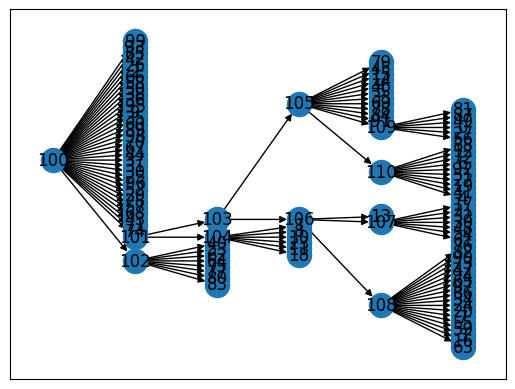

In [88]:
g = clust.condensed_tree_.to_networkx()
g.graph['rankdir']='LR'
# g.graph['nodesep']='200'

pos=nx.nx_agraph.graphviz_layout(g, root=100, prog='dot')
nx.draw_networkx(g, pos=pos)
# node_size=np.array([5*n[-1].get('size',1) for n in g.nodes.data()])


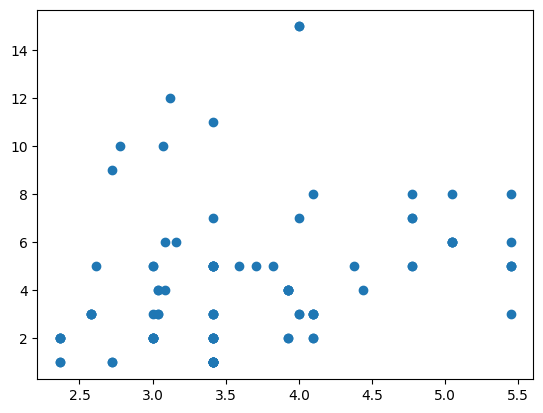

In [89]:
causet = clust.condensed_tree_.to_pandas().pipe(lambda df: df[df['child_size']==1]).sort_values(by='lambda_val')

plt.scatter(causet.lambda_val, papers.loc[causet.child].sum(axis=1).values)

In [90]:
pairwise_distances(papers, metric='cosine')

array([[3.33066907e-16, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 7.32738758e-01],
       [1.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       ...,
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        2.22044605e-16, 5.00000000e-01, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        5.00000000e-01, 2.22044605e-16, 1.00000000e+00],
       [7.32738758e-01, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 2.22044605e-16]])

In [91]:
causet[causet.child_size==1]

,parent,child,lambda_val,child_size
0,100,99,2.366025,1
1,100,93,2.366025,1
2,100,85,2.366025,1
3,100,42,2.366025,1
4,100,26,2.366025,1
...,...,...,...,...
106,110,22,5.449490,1
99,110,92,5.449490,1
108,110,41,5.449490,1
105,110,51,5.449490,1


In [92]:
papers.loc[causet.lambda_val.argmin()]

author
author_01    0
author_02    0
author_03    1
author_04    0
author_05    0
author_06    0
author_07    0
author_08    0
author_09    0
author_10    1
author_11    1
author_12    0
author_13    1
author_14    0
author_15    1
author_16    1
author_17    0
author_18    0
author_19    0
author_20    1
Name: 0, dtype: int64

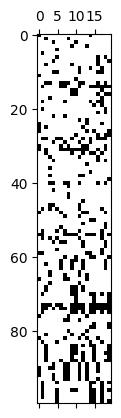

In [94]:
plt.spy(papers.loc[causet.child])

In [95]:
clust.probabilities_

array([1.        , 1.        , 0.        , 1.        , 1.        ,
       0.95847947, 1.        , 0.86753088, 1.        , 0.        ,
       1.        , 1.        , 1.        , 0.        , 0.95847947,
       0.93352484, 1.        , 1.        , 1.        , 1.        ,
       0.81212528, 1.        , 1.        , 1.        , 0.81212528,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.97628422, 0.81212528,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       1.        , 1.        , 0.        , 0.        , 0.        ,
       0.90496146, 0.95847947, 0.67675269, 1.        , 1.        ,
       0.        , 1.        , 0.        , 1.        , 1.        ,
       1.        , 1.        , 0.        , 0.        , 1.        ,
       0.        , 1.        , 1.        , 1.        , 1.        ,
       0.77840541, 0.        , 0.        , 0.        , 0.97628422,
       0.        , 0.        , 1.        , 0.67675269, 0.     

In [96]:
clust.labels_

array([ 2,  1, -1,  4,  2,  2,  2,  4,  1, -1,  1,  1,  2, -1,  2,  2,  4,
        3,  1,  2,  4,  3,  2,  1,  4, -1, -1,  2, -1, -1, -1, -1,  3,  2,
        4, -1, -1, -1, -1,  3,  0,  2, -1, -1, -1,  2,  2,  4,  3,  2, -1,
        2, -1,  0,  3,  4,  2, -1, -1,  4, -1,  3,  0,  4,  0,  4, -1, -1,
       -1,  2, -1, -1,  2,  4, -1,  0,  4,  0,  2,  2,  0,  2,  4,  0,  2,
       -1,  4,  2,  2, -1,  4,  2,  2, -1,  4, -1, -1,  4, -1, -1])

In [97]:
hdbscan.all_points_membership_vectors(clust)

AttributeError: No prediction data was generated